In [11]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
with h5py.File('../data/block_o_spectra.hdf5') as f:
    fluxs = np.copy(f['fluxs'])
    waves = np.copy(f['waves'])
    star_names = np.copy(f['star_name'])
    
N = len(star_names)

(0.2, 1.2)

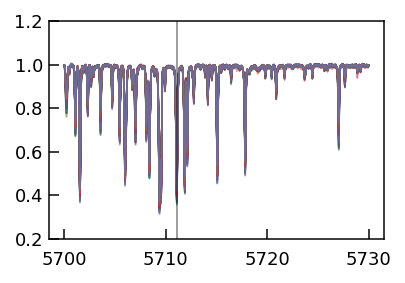

In [13]:
Mg_line = 5711.088
inds = (waves > 5700.) & (waves < 5730.)
for i in range(N):
    plt.step(waves[inds], fluxs[i,inds], alpha=0.5)
plt.axvline(Mg_line, color='k', alpha=0.5)
plt.ylim([0.2,1.2])

In [15]:
# Hackety fucking hack to remove missing data
tiny = 0.001 # magic
mask = fluxs > tiny
keep = np.sum(mask, axis=0) == N # OMG this is HARSH
# The line above saves us from having to repair the missing data.
# Hogg knows how to do that.

In [16]:
# trim data
waves = waves[keep]
fluxs = fluxs[:, keep]
mask = mask[:, keep]
np.shape(fluxs)

(79, 306332)

In [71]:
def make_B(waves, start_order = 2, stop_order = 20):
    thetas = np.pi * (waves - waves.min())/(waves.max() - waves.min())
    K = stop_order - start_order
    B = np.zeros((2 * K, len(thetas)))
    for k in range(K):
        B[2*k] = np.cos(k * thetas)
        B[2*k+1] = np.sin(k * thetas)
    return B
    

def fit_params(thisn, hypers = (0.1, 1.e6), mask=0.):
    """
    bugs:
    -----
    - Depends on global variables.
    - Repeating code.
    """
    if len(mask) == 1:
        print "No mask provided, using all pixels"
        mask = np.ones(len(fluxs[thisn]))
    A = np.delete(fluxs, n, axis=0)
    A = A[:, mask]
    B = make_B(waves[mask])
    K,M = np.shape(B)
    A = np.append(A, B, axis=0)
    ATA = np.dot(A, A.T)
    ATy = np.dot(A, fluxs[thisn][mask])
    lambdainv_diag = np.repeat(hypers[0] * (N * N), N-1) # inverse variance
    lambdainv_diag = np.append(lambdainv_diag, np.repeat(hypers[1], K))
    lambdainv = np.diag(lambdainv_diag)
    # regularized least-square fit
    x = np.linalg.solve(ATA + lambdainv, ATy)
    return x

def predict_spectrum(thisn, x):
    A = np.delete(fluxs, n, axis=0)
    A = np.append(A, make_B(waves), axis=0)
    return np.dot(A.T, x)

NIST has Mg lines at 571-574 nm, so we'll cut 5700-5715 A out.

In [72]:
def mask_function(x):
    if (x > 5700.) and (x < 5710.):
        return True
    elif (x > 5715.) and (x < 5730.):
        return True
    return False

In [73]:
mask = np.asarray([mask_function(x) for x in waves])

In [74]:
n = 0 # spectrum to predict
x = fit_params(n, mask=mask)
predicted_ys = predict_spectrum(n, x)

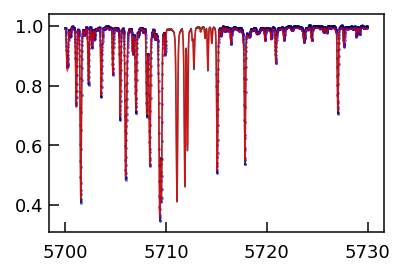

In [90]:
inds = (waves > 5700.) & (waves < 5730.)
plt.plot(waves[inds], fluxs[n][inds], color='k', alpha=0.7, label='true data')
plt.scatter(waves[mask], fluxs[n][mask], color='b', marker='o', s=4, alpha=0.4, label='data used in prediction')
plt.plot(waves[inds], predicted_ys[inds], color='r', alpha=0.7, label='prediction')
#plt.legend()

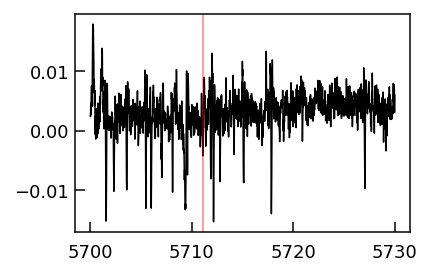

In [89]:
plt.plot(waves[inds], fluxs[n][inds] - predicted_ys[inds], color='k')
plt.axvline(Mg_line, color='r', alpha=0.5)